# ECE 219 Project 2: Data Representations and Clustering

In [1]:
# import all necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# allows matlab plots to be generated in line
%matplotlib inline

from google.colab import drive
drive.mount("/content/drive/")

# add system path to current directory
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECE_219/Project2')

Mounted at /content/drive/


# Part 1 - Clustering on Text Data

In [2]:
from sklearn.datasets import fetch_20newsgroups

# load whole dataset
removed_items = ('headers', 'footers')
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=removed_items,
                                      shuffle=True,
                                      random_state=0)
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     remove=removed_items,
                                     shuffle=True,
                                     random_state=0)

Define two classes based on a well-separable subset of samples and newly mark the class label

In [3]:
# class 1 categories - label [0, 1, 2, 3] -> label 0
class1_cats = ['comp.graphics', 'comp.os.ms-windows.misc',
               'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']

# class 2 categories - label [4, 5, 6, 7] -> label 1
class2_cats = ['rec.autos', 'rec.motorcycles', 
               'rec.sport.baseball', 'rec.sport.hockey']

# load newsgroups subsets and remove headers&footers
removed_items = ('headers', 'footers')
subset_train = fetch_20newsgroups(subset='train', 
                                  remove=removed_items, 
                                  categories=class1_cats+class2_cats,
                                  shuffle=True,
                                  random_state=0)
subset_test = fetch_20newsgroups(subset='test', 
                                 remove=removed_items, 
                                 categories=class1_cats+class2_cats,
                                 shuffle=True,
                                 random_state=0)

# convert to new class labels: class 1 - label 0, class 2 - label 1
subset_train.target = np.isin(subset_train.target, [4, 5, 6, 7]).astype(int)
subset_test.target = np.isin(subset_test.target, [4, 5, 6, 7]).astype(int)

# print some info
print('Class names: ', subset_train.target_names)
unique_labels, category_sizes = np.unique(subset_train.target, return_counts=True)
print(f"{unique_labels.shape[0]} categories - {len(subset_train.data)} documents")
print(f"Class 0: {category_sizes[0]} documents")
print(f"Class 1: {category_sizes[1]} documents")

# take a look
print(' ')
print(subset_train.filenames[:5])
print(subset_train.target[:5])

Class names:  ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
2 categories - 4732 documents
Class 0: 2343 documents
Class 1: 2389 documents
 
['/root/scikit_learn_data/20news_home/20news-bydate-train/rec.sport.baseball/102694'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/rec.autos/103185'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38342'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/comp.os.ms-windows.misc/9686'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38550']
[1 1 0 0 0]


## Clustering with Sparse Text Representations

### 1. Generate sparse TF-IDF representations: 

Following the steps in Project 1, transform the documents into TF-IDF vectors. Use <b>min_df = 3</b>, exclude the stopwords (no need to do stemming or lemmatization), and remove the headers and footers. No need to do any additional data cleaning.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

t0 = time()

# convert to TF-IDF matrix
min_df = 3
tfidf_vec = TfidfVectorizer(min_df=min_df, stop_words='english')
X_train_tfidf = tfidf_vec.fit_transform(subset_train.data)

print('Vectorization done in {:.3f} s'.format(time() - t0))
print('Shape of the TF-IDF converted matrix: {}'.format(X_train_tfidf.shape))

Vectorization done in 1.065 s
Shape of the TF-IDF converted matrix: (4732, 17131)


<div class="alert alert-block alert-success">
<b>QUESTION 1:</b> Report the dimensions of the TF-IDF matrix you obtain.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 1:</b> The output dimension of the TF-IDF converted matrix is (4732 x 17131)
</div>

### 2. Clustering: 

Apply K-means clustering with <b>k = 2</b> using the TF-IDF data. Note that the KMeans class in sklearn has parameters named <b>random_state, max_iter and n_init</b>. Please use <b>random_state=0, max_iter ≥ 1000 and n_init ≥ 30.</b>

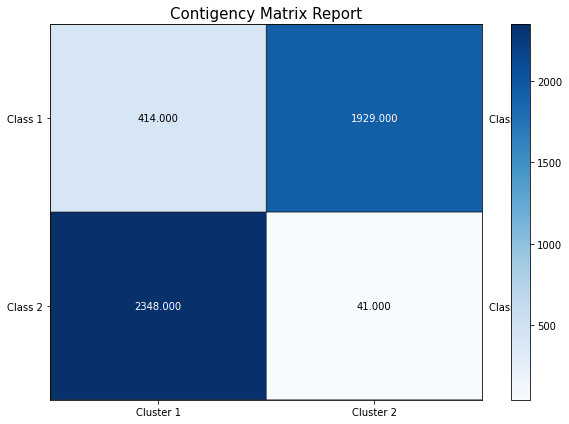

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from plotmat import plot_mat

# setup K-means model
k = 2
kmeans = KMeans(n_clusters=k, max_iter=2000,
                n_init=100, random_state=0)

# train the model
kmeans.fit(X_train_tfidf)

# report contigency matrix
cmat = contingency_matrix(subset_train.target, kmeans.labels_)
unique_clusters, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

# plot
xlabels = [f'Cluster {i+1}' for i in range(len(unique_clusters))]
ylabels = [f'Class {i+1}' for i in range(len(unique_labels))]
cmat_title = 'Contigency Matrix Report'
plot_mat(mat=cmat, xticklabels = xlabels, yticklabels = ylabels, 
         size=(8,6), title = cmat_title, pic_fname = cmat_title)

<div class="alert alert-block alert-success">
<b>QUESTION 2:</b> Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix. Does the contingency matrix have to be square-shaped?
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 2:</b> 

The plotted contingency table is shown above. 

No, the contingency matrix doesn't have to be square-shaped since the labels on x- and y-axis are not the same. In our case, x-axis corresponds to the clusters and y-axis to the classes. This means that if we, for example, change $k=4$, we will get a (2x4) contingency matrix
</div>

Clustering algorithms are fundamentally unsupervised learning methods. However, since we happen to have class labels for this specific dataset, it is possible to use evaluation metrics that leverage this “supervised” ground truth information to quantify the quality of the resulting clusters. Examples of such metrics are the following:

<ul>
  <li><b>Homogeneity</b>, which quantifies how much clusters contain only members of a single class</li>
  <li><b>Completeness</b>, which quantifies how much members of a given class are assigned to the same clusters</li>
  <li><b>V-measure</b>, the harmonic mean of completeness and homogeneity</li>
  <li><b>Rand-Index</b>, which measures how frequently pairs of data points are grouped consistently according to the result of the clustering algorithm and the ground truth class assignment</li>
  <li><b>Adjusted Rand-Index</b>, a chance-adjusted Rand-Index such that random cluster assignment have an ARI of 0.0 in expectation </li>
  <li><b>Silhouette Coefficient</b>, is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.</li>
</ul>

In [11]:
from sklearn.metrics import homogeneity_score, completeness_score
from sklearn.metrics import v_measure_score, rand_score
from sklearn.metrics import adjusted_rand_score, silhouette_score

# evaluation
km_scores = {}
km_scores["Homogeneity"] = homogeneity_score(subset_train.target, kmeans.labels_)
km_scores["Completeness"] = completeness_score(subset_train.target, kmeans.labels_)
km_scores["V-measure"] = v_measure_score(subset_train.target, kmeans.labels_)
# km_scores["Rand_Index"] = rand_score(subset_train.target, kmeans.labels_)
km_scores["Adjusted Rand-Index"] = adjusted_rand_score(subset_train.target, kmeans.labels_)
km_scores["Silhouette Coefficient"] = silhouette_score(X_train_tfidf, kmeans.labels_)

# Report the 5 clustering measures
km_scores

{'Homogeneity': 0.5834030920023915,
 'Completeness': 0.5954525486253484,
 'V-measure': 0.589366239658909,
 'Adjusted Rand-Index': 0.6522945138990512,
 'Silhouette Coefficient': 0.0048285485321181406}

<div class="alert alert-block alert-success">
<b>QUESTION 3:</b> Report the 5 clustering measures explained in the introduction for Kmeans clustering.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 3:</b> The 5 clustering measures are reported above.
</div>

## Clustering with Dense Text Representations

### 1. Generate dense representations for better K-Means Clustering

<ul>
  <li>(a) First we want to find the effective dimension of the data through inspection of the top singular values of the TF-IDF matrix and see how many of them are significant in reconstructing the matrix with the truncated SVD representation. A guideline is to see what ratio of the variance of the original data is retained after the dimensionality reduction. </li>
</ul>

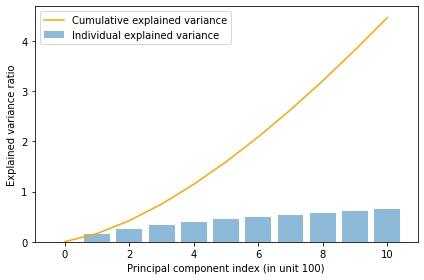

In [19]:
from sklearn.decomposition import TruncatedSVD

# Define the number of components
n_components=[1, 100, 200, 300, 400, 500, 
              600, 700, 800, 900, 1000]
ExVar_ratios = []
ExVar_ratios_sum = []
sum_ratio = 0

for r in n_components:    
    # create SVD object
    svd = TruncatedSVD(n_components=r, n_iter=5, random_state=0)

    # fit SVD model on with TF-IDF processed matrix
    X_train_svd = svd.fit_transform(X_train_tfidf)
    
    # store explained variance ratio for the plot
    ExVar_ratio = svd.explained_variance_ratio_.sum()
    ExVar_ratios.append(ExVar_ratio)
    sum_ratio += ExVar_ratio
    ExVar_ratios_sum.append(sum_ratio)

plt.bar(range(0,len(ExVar_ratios_sum)), ExVar_ratios, alpha=0.5, 
        align='center', label='Individual explained variance')
# plt.step(range(0,len(ExVar_ratios_sum)), ExVar_ratios_sum, 
#          where='mid',label='Cumulative explained variance')
plt.plot(range(0,len(ExVar_ratios_sum)), ExVar_ratios_sum, 
         color='orange', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index (in unit 100)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>QUESTION 4:</b> Report the plot of the percentage of variance that the top $r$ principle components retain v.s. $r$, for $r$ = 1 to 1000.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 4:</b> The result is shown above. Here, I only test the following values: $r = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]$ to save some time.
</div>

<ul>
  <li>(b) Now, use the following two methods to reduce the dimension of the data. Sweep over the dimension parameters for each method, and choose one that yields better results in terms of clustering purity metrics. </li>
  <ul>
      <li>Truncated SVD / PCA: Note that you don’t need to perform SVD multiple times: performing SVD with $r$ = 1000 gives you the data projected on all the top 1000 principle components, so for smaller $r$’s, you just need to exclude the least important features.</li>
      <li>NMF</li>
  </ul>
</ul>

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


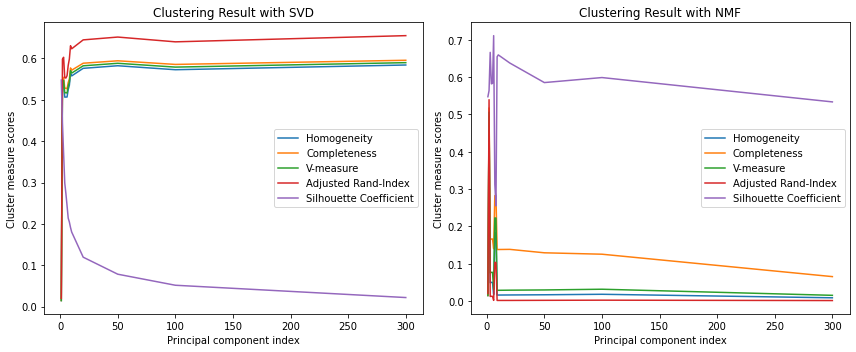

In [20]:
from sklearn.decomposition import TruncatedSVD, NMF

# function for calculating all cluster measures
def cluster_evaluation(X, y_true, y_pred):
    score = {}
    score["Homogeneity"] = homogeneity_score(y_true, y_pred)
    score["Completeness"] = completeness_score(y_true, y_pred)
    score["V-measure"] = v_measure_score(y_true, y_pred)
    score["Adjusted Rand-Index"] = adjusted_rand_score(y_true, y_pred)
    score["Silhouette Coefficient"] = silhouette_score(X, y_pred)
    
    return score


# init
k = 2
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
scores = {'SVD': {'Homogeneity': [], "Completeness": [], "V-measure": [], 
                  "Adjusted Rand-Index": [], "Silhouette Coefficient": []}, 
          'NMF': {'Homogeneity': [], "Completeness": [], "V-measure": [], 
                  "Adjusted Rand-Index": [], "Silhouette Coefficient": []}}
score_names = ['Homogeneity', "Completeness", "V-measure", 
               "Adjusted Rand-Index", "Silhouette Coefficient"]

for r in n_components:  
    # SVD
    svd = TruncatedSVD(n_components=r, n_iter=5, random_state=0)
    X_train_svd = svd.fit_transform(X_train_tfidf)
    # setup K-means model for SVD
    svd_kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=50, random_state=0)
    # train
    svd_kmeans.fit(X_train_svd)
    # evaluation
    svd_score = cluster_evaluation(X_train_svd, 
                                   subset_train.target, svd_kmeans.labels_)
    for name in score_names:
        scores['SVD'][name].append(svd_score[name])

    # NMF
    nmf = NMF(n_components=r, init='random', random_state=0)
    W_nmf = nmf.fit_transform(X_train_tfidf)
    # setup K-means model for NMF
    nmf_kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=50, random_state=0)
    # train
    nmf_kmeans.fit(W_nmf)
    # evaluation
    nmf_score = cluster_evaluation(W_nmf, 
                                   subset_train.target, nmf_kmeans.labels_)
    for name in score_names:
        scores['NMF'][name].append(nmf_score[name])


# plot results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for name in score_names:
    axes[0].plot(n_components, scores['SVD'][name], label=name)
    axes[1].plot(n_components, scores['NMF'][name], label=name)

axes[0].set_xlabel("Principal component index")
axes[0].set_ylabel("Cluster measure scores")
axes[0].set_title('Clustering Result with SVD')
axes[0].legend()

axes[1].set_xlabel("Principal component index")
axes[1].set_ylabel("Cluster measure scores")
axes[1].set_title('Clustering Result with NMF')
axes[1].legend()

fig.tight_layout()

#### find out the best $r$ for SVD and NMF

In [22]:
# SVD
print('For SVD results')
for name in score_names:
    best_idx = np.argmax(scores['SVD'][name])
    print('- Best r in {} is: r = {}'\
          ' with value {}'.format(name, n_components[best_idx], 
                                  np.max(scores['SVD'][name])))

# NMF
print('\nFor NMF results')
for name in score_names:
    best_idx = np.argmax(scores['NMF'][name])
    print('- Best r in {} is: r = {}'\
          ' with value {}'.format(name, n_components[best_idx], 
                                  np.max(scores['NMF'][name])))

For SVD results
- Best r in Homogeneity is: r = 300 with value 0.5840574224178467
- Best r in Completeness is: r = 300 with value 0.595502213276126
- Best r in V-measure is: r = 300 with value 0.5897242957547468
- Best r in Adjusted Rand-Index is: r = 300 with value 0.655028881549984
- Best r in Silhouette Coefficient is: r = 1 with value 0.5474965183265669

For NMF results
- Best r in Homogeneity is: r = 2 with value 0.4950453839087971
- Best r in Completeness is: r = 2 with value 0.5174355469228464
- Best r in V-measure is: r = 2 with value 0.5059928956174533
- Best r in Adjusted Rand-Index is: r = 2 with value 0.5395035409494571
- Best r in Silhouette Coefficient is: r = 6 with value 0.7111108262227275


<div class="alert alert-block alert-success">
<b>QUESTION 5:</b> Let r be the dimension that we want to reduce the data to (i.e. n components). Try r = 1 − 10, 20, 50, 100, 300, and plot the 5 measure scores v.s. r for both SVD and NMF. Report a good choice of r for SVD and NMF respectively.
    
Note: In the choice of r, there is a trade-off between the information preservation, and better performance of k-means in lower dimensions.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 5:</b> The plots of 5 measure scores v.s. $r$ for both SVD and NMF are shown above. Based on the result, a good choice of $r$ for SVD is $r = 300$ and for NMF is $r = 2$
</div>

<div class="alert alert-block alert-success">
<b>QUESTION 6:</b> How do you explain the non-monotonic behavior of the measures as $r$ increases?
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 6:</b> In the plot of NMF, we do observe a pretty strong non-monotonic behavior of the measures as $r$ increases. One potential reason for that, as mentioned in the project instruction, is the tendency of yielding similar Euclidean distance between data points through K-Means in higher-dimensional space. Therefore, there is a trade-off between the information preservation and better performance of utilizing K-Means with lower-dimensional data features. Moreover, the higher the dimension of the data points is, the more complex the spatial structure is. Hense, it is potentially difficult for K-Means to correctly cluster as it implicitly assumes that clusters are isotropically shaped.
</div>


<div class="alert alert-block alert-success">
<b>QUESTION 7:</b> Are these measures on average better than those computed in Question 3?
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 7:</b> For the measures with SVD at here, yes, it yields a slightly better performance on average in the first 4 metrics and a lot in silhouette coefficient, compared with those in Q3. However, for the measures with NMF, the results are mostly worse, besides the silhouette coefficient.
</div>

### 2. Visualize the clusters

We can visualize the clustering results by projecting the dimension-reduced data points onto a 2-D plane by once again using SVD, and coloring the points according to the:
<ul>
  <li>Ground truth class label</li>
  <li>Clustering label</li>
</ul>
respectively.

#### SVD with optimal choice of $r$ for K-Means clustering ($r = 100$)

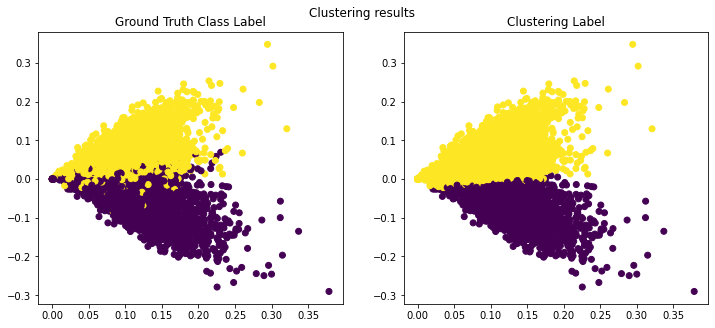

In [23]:
# best choice of r based on the result shown above
r = 300
svd = TruncatedSVD(n_components=r, n_iter=5, random_state=0)
X_train_svd = svd.fit_transform(X_train_tfidf)
# setup K-means model for SVD
k = 2
svd_kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=50, random_state=0)
# train
svd_kmeans.fit(X_train_svd)

# project into data into 2-D plane for visualization
X_svd_2d = TruncatedSVD(n_components=2, n_iter=5,
                        random_state=0).fit_transform(X_train_svd)

# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].scatter(X_svd_2d[:, 0], X_svd_2d[:, 1], c=subset_train.target)
axs[0].set_title("Ground Truth Class Label")

axs[1].scatter(X_svd_2d[:, 0], X_svd_2d[:, 1], c=svd_kmeans.labels_)
axs[1].set_title("Clustering Label")

plt.suptitle("Clustering results").set_y(0.95)
plt.show()

#### NMF with optimal choice of $r$ for K-Means clustering ($r = 2$)

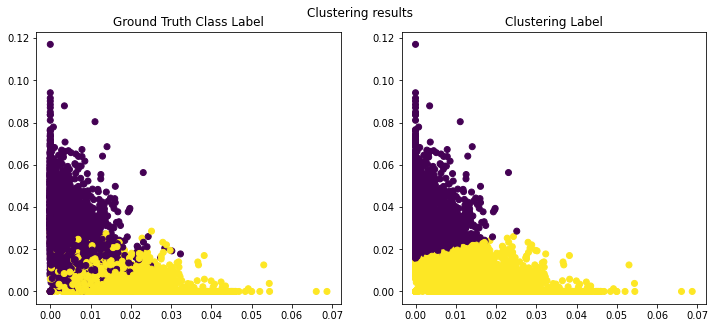

In [24]:
# best choice of r based on the result shown above
r = 2
nmf = NMF(n_components=r, init='random', random_state=0)
W_nmf = nmf.fit_transform(X_train_tfidf)
# setup K-means model for SVD
k = 2
nmf_kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=50, random_state=0)
# train
nmf_kmeans.fit(W_nmf)

# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].scatter(W_nmf[:, 0], W_nmf[:, 1], c=subset_train.target)
axs[0].set_title("Ground Truth Class Label")

axs[1].scatter(W_nmf[:, 0], W_nmf[:, 1], c=nmf_kmeans.labels_)
axs[1].set_title("Clustering Label")

plt.suptitle("Clustering results").set_y(0.95)
plt.show()

<div class="alert alert-block alert-success">
<b>QUESTION 8:</b> Visualize the clustering results for:
<ul>
  <li>SVD with your optimal choice of r for K-Means clustering</li>
  <li>NMF with your choice of r for K-Means clustering</li>
</ul>
    
To recap, you can accomplish this by first creating the dense representations and then once again projecting these representations into a 2-D plane for visualization. 
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 8:</b> Both SVD and NMF clustering visualizations are shown above. 
</div>

<div class="alert alert-block alert-success">
<b>QUESTION 9:</b> What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 9:</b> In general, we can notice that there is a clear boundary in the clustering label plots of both SVD and NMF, which corresponds to the characteristics of assuming isotropically shaped clusters from K-Means. However, by comparing to the ground truth plots of both which include overlap between two classes, we know that this data distribution is not ideal for K-Means clustering. Especially in NMF, the overlap is pretty large, and thus, there are lots of misclassification, leading to lower performance.
</div>

### 3. Clustering of the Entire 20 Classes

We have been dealing with a relatively simple clustering task with only two well-separated classes. Now let’s face a more challenging one: clustering for the entire 20 categories in the 20newsgroups dataset.

In [7]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score
from sklearn.metrics import v_measure_score, rand_score
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from plotmat import plot_mat


# function for calculating all cluster measures
def cluster_evaluation(X, y_true, y_pred):
    score = {}
    score["Homogeneity"] = homogeneity_score(y_true, y_pred)
    score["Completeness"] = completeness_score(y_true, y_pred)
    score["V-measure"] = v_measure_score(y_true, y_pred)
    score["Adjusted Rand-Index"] = adjusted_rand_score(y_true, y_pred)
    score["Silhouette Coefficient"] = silhouette_score(X, y_pred)
    
    return score


# load whole dataset
removed_items = ('headers', 'footers')
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=removed_items,
                                      shuffle=True,
                                      random_state=0)
unique_labels, category_sizes = np.unique(newsgroups_train.target, 
                                          return_counts=True)

# parameters
min_df = 3  # for min_df in TF-IDF
k = 20      # for n_clusters

# convert to TF-IDF matrix
tfidf_vec = TfidfVectorizer(min_df=min_df, stop_words='english')
X_train_tfidf = tfidf_vec.fit_transform(newsgroups_train.data)

#### Visualizing the contingency matrix and report the five clustering metrics of SVD

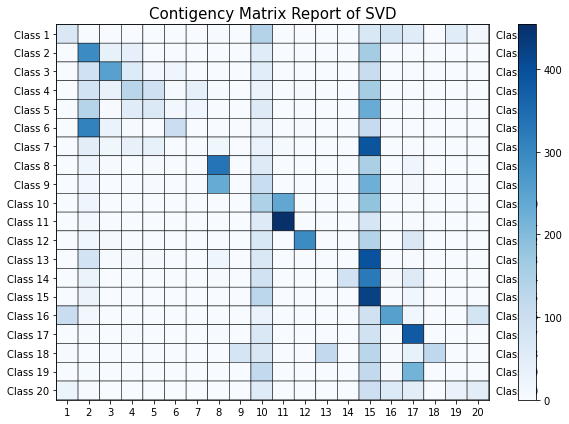


Report of 5 clustering metrics of SVD:


{'Homogeneity': 0.33111354494447337,
 'Completeness': 0.4232367765815317,
 'V-measure': 0.3715499959257377,
 'Adjusted Rand-Index': 0.10629510031842208,
 'Silhouette Coefficient': 0.008902149910074009}

In [33]:
# SVD
svd = TruncatedSVD(n_components=300, n_iter=5, random_state=0)
X_train_svd = svd.fit_transform(X_train_tfidf)
# K-mean train and evaluate
svd_kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=50, random_state=0)
svd_kmeans.fit(X_train_svd)

# visualize contigency matrix
cmat_svd = contingency_matrix(newsgroups_train.target, svd_kmeans.labels_)
unique_clusters_svd, cluster_sizes_svd = np.unique(svd_kmeans.labels_,
                                                   return_counts=True)
rows, cols = linear_sum_assignment(cmat_svd, maximize=True)
# xlabels = [f'Cluster {i+1}' for i in range(len(unique_clusters_svd))]
xlabels = [f'{i+1}' for i in range(len(unique_clusters_svd))]
ylabels = [f'Class {i+1}' for i in range(len(unique_labels))]
cmat_title = 'Contigency Matrix Report of SVD'
plot_mat(mat=cmat_svd[rows[:, np.newaxis], cols], size=(8, 6),
         xticklabels=xlabels, yticklabels=ylabels, if_show_values=False,
         title=cmat_title, pic_fname=cmat_title)

# report evaluation
svd_score = cluster_evaluation(X_train_svd, newsgroups_train.target, 
                               svd_kmeans.labels_)
print('\nReport of 5 clustering metrics of SVD:')
svd_score

#### Visualizing the contingency matrix and report the five clustering metrics of NMF

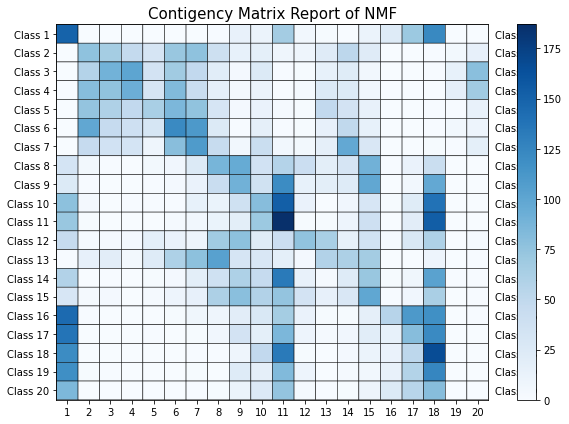


Report of 5 clustering metrics of NMF:


{'Homogeneity': 0.1950827972264987,
 'Completeness': 0.2078578721585144,
 'V-measure': 0.20126782033751764,
 'Adjusted Rand-Index': 0.05778775797174292,
 'Silhouette Coefficient': 0.37328775120685537}

In [34]:
# NMF
nmf = NMF(n_components=2, init='random', random_state=0)
W_nmf = nmf.fit_transform(X_train_tfidf)
nmf_kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=50, random_state=0)
nmf_kmeans.fit(W_nmf)

# visualize contigency matrix
cmat_nmf = contingency_matrix(newsgroups_train.target, nmf_kmeans.labels_)
unique_clusters_nmf, cluster_sizes_nmf = np.unique(nmf_kmeans.labels_,
                                                   return_counts=True)
rows, cols = linear_sum_assignment(cmat_nmf, maximize=True)
# xlabels = [f'Cluster {i+1}' for i in range(len(unique_clusters_svd))]
xlabels = [f'{i+1}' for i in range(len(unique_clusters_nmf))]
ylabels = [f'Class {i+1}' for i in range(len(unique_labels))]
cmat_title = 'Contigency Matrix Report of NMF'
plot_mat(mat=cmat_nmf[rows[:, np.newaxis], cols], size=(8, 6),
         xticklabels=xlabels, yticklabels=ylabels, if_show_values=False,
         title=cmat_title, pic_fname=cmat_title)

# report evaluation
nmf_score = cluster_evaluation(W_nmf, newsgroups_train.target, 
                               nmf_kmeans.labels_)
print('\nReport of 5 clustering metrics of NMF:')
nmf_score

<div class="alert alert-block alert-success">
<b>QUESTION 10:</b> Load documents with the same configuration as in Question 1, but for ALL 20 categories. Construct the TF-IDF matrix, reduce its dimensionality using BOTH NMF and SVD (specify settings you choose and why), and perform K-Means clustering with <b>k=20</b>. <b>Visualize the contingency matrix and report the five clustering metrics (DO BOTH NMF AND SVD).</b>
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 10:</b> The visualized contingency matrix as well as the report of 5 clustering metrics for both SVD and NMF are shown above. Here we set $r = 300$ for SVD and $r = 2$ for NMF as they yield the best result based on the experiment in Q5. I do have experiment with large $r$ such as $r = 100$ for NMF. However, it takes around 8 minutes per run, which is way too inefficient. Therefore, I change it back to smaller value.
</div>

### 4. UMAP

The clustering performance is poor for the 20 categories data. To see if we can improve this performance, we consider UMAP for dimensionality reduction. UMAP uses cosine distances to compare representations. Consider two documents that are about the same
topic and are similar, but one is very long while the other is short. The magnitude of the TF-IDF vector will be high for the long document and low for the short one, even though the orientation of their TF-IDF vectors might be very close. In this case, the cosine distance adopted by UMAP will correctly identify the similarity, whereas Euclidean distance might fail.

In [4]:
# !pip install umap-learn

In [8]:
from umap import UMAP

def apply_umap_report(r, metric):
    # set up UMAP
    umap = UMAP(n_components=r, metric=metric, random_state=0)
    X_train_umap = umap.fit_transform(X_train_tfidf)
  
    # set up K-Means
    umap_kmeans = KMeans(n_clusters=20, max_iter=1000, n_init=50, random_state=0)
    umap_kmeans.fit(X_train_umap)

    # visualize contigency matrix
    cmat_umap = contingency_matrix(newsgroups_train.target, umap_kmeans.labels_)
    unique_clusters_umap, cluster_sizes_umap = np.unique(umap_kmeans.labels_,
                                                        return_counts=True)
    rows, cols = linear_sum_assignment(cmat_umap, maximize=True)
    # xlabels = [f'Cluster {i+1}' for i in range(len(unique_clusters_svd))]
    xlabels = [f'{i+1}' for i in range(len(unique_clusters_umap))]
    ylabels = [f'Class {i+1}' for i in range(len(unique_labels))]
    cmat_title = 'Contigency Matrix Report of UMAP with ({}, {}) pair'.format(r, metric)
    plot_mat(mat=cmat_umap[rows[:, np.newaxis], cols], size=(8, 6),
             xticklabels=xlabels, yticklabels=ylabels, if_show_values=False,
             title=cmat_title, pic_fname=cmat_title)

    # report evaluation
    umap_score = cluster_evaluation(X_train_umap, newsgroups_train.target, 
                                    umap_kmeans.labels_)
    
    return umap_score

#### UMAP with $r = 5$ & metric = "cosine"

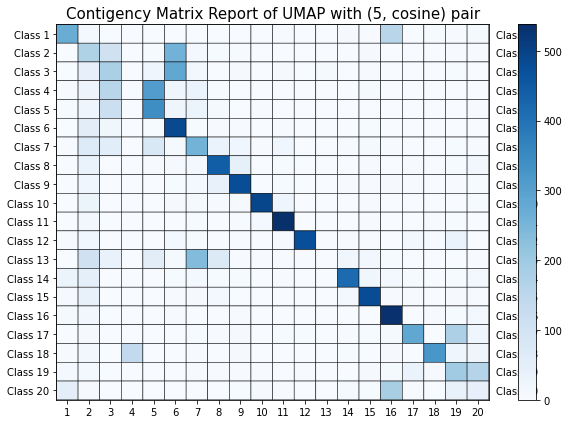


Report of 5 clustering metrics of UMAP:
- setting: r = 5, metric = "cosine"


{'Homogeneity': 0.560647320029495,
 'Completeness': 0.583611426951223,
 'V-measure': 0.5718989403789216,
 'Adjusted Rand-Index': 0.4230273745776628,
 'Silhouette Coefficient': 0.37965083}

In [9]:
umap_score = apply_umap_report(r=5, metric='cosine')
print('\nReport of 5 clustering metrics of UMAP:')
print('- setting: r = 5, metric = \"cosine\"')
umap_score

#### UMAP with $r = 20$ & metric = "cosine"

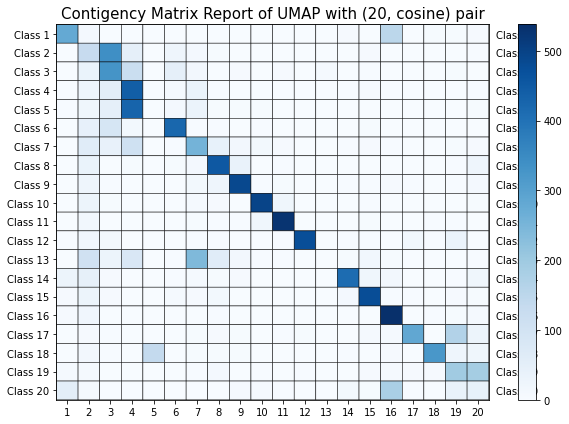


Report of 5 clustering metrics of UMAP:
- setting: r = 20, metric = "cosine"


{'Homogeneity': 0.5689519254949048,
 'Completeness': 0.5943209079687889,
 'V-measure': 0.5813597897647045,
 'Adjusted Rand-Index': 0.436592713134769,
 'Silhouette Coefficient': 0.37802404}

In [10]:
umap_score = apply_umap_report(r=20, metric='cosine')
print('\nReport of 5 clustering metrics of UMAP:')
print('- setting: r = 20, metric = \"cosine\"')
umap_score

#### UMAP with $r = 200$ & metric = "cosine"

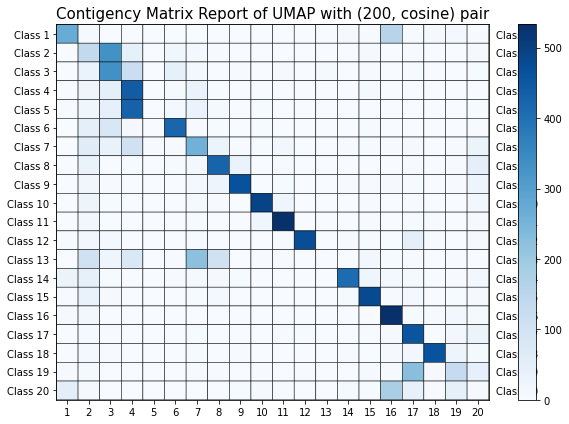


Report of 5 clustering metrics of UMAP:
- setting: r = 200, metric = "cosine"


{'Homogeneity': 0.569948128458261,
 'Completeness': 0.6018289524090229,
 'V-measure': 0.585454845769198,
 'Adjusted Rand-Index': 0.4481831915801822,
 'Silhouette Coefficient': 0.38318607}

In [11]:
umap_score = apply_umap_report(r=200, metric='cosine')
print('\nReport of 5 clustering metrics of UMAP:')
print('- setting: r = 200, metric = \"cosine\"')
umap_score

#### UMAP with $r = 5$ & metric = "euclidean"

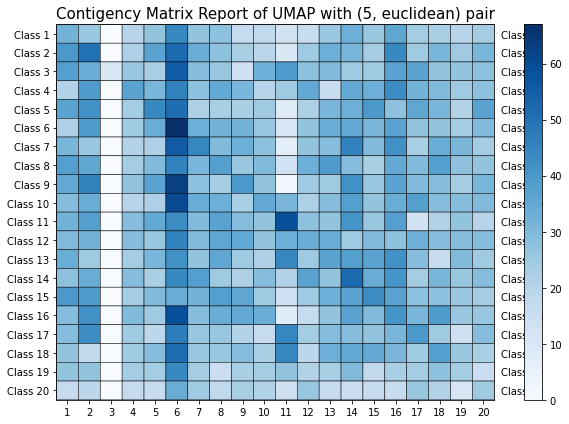


Report of 5 clustering metrics of UMAP:
- setting: r = 5, metric = "euclidean"


{'Homogeneity': 0.009308692426102525,
 'Completeness': 0.009490205354500056,
 'V-measure': 0.009398572590436268,
 'Adjusted Rand-Index': 0.0009043184700830223,
 'Silhouette Coefficient': 0.41387036}

In [12]:
umap_score = apply_umap_report(r=5, metric='euclidean')
print('\nReport of 5 clustering metrics of UMAP:')
print('- setting: r = 5, metric = \"euclidean\"')
umap_score

#### UMAP with $r = 20$ & metric = "euclidean"

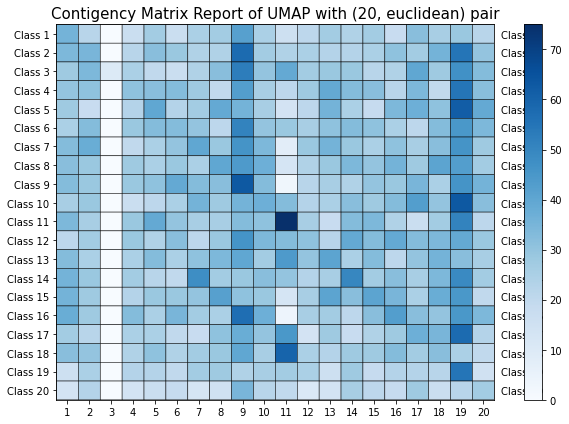


Report of 5 clustering metrics of UMAP:
- setting: r = 20, metric = "euclidean"


{'Homogeneity': 0.010361894261561156,
 'Completeness': 0.010555385729010798,
 'V-measure': 0.010457745066595615,
 'Adjusted Rand-Index': 0.001455752684803986,
 'Silhouette Coefficient': 0.41455543}

In [13]:
umap_score = apply_umap_report(r=20, metric='euclidean')
print('\nReport of 5 clustering metrics of UMAP:')
print('- setting: r = 20, metric = \"euclidean\"')
umap_score

#### UMAP with $r = 200$ & metric = "euclidean"

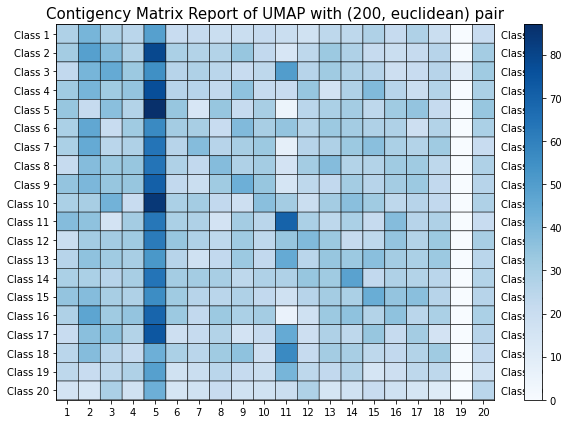


Report of 5 clustering metrics of UMAP:
- setting: r = 200, metric = "euclidean"


{'Homogeneity': 0.00949511281383021,
 'Completeness': 0.009727737417701254,
 'V-measure': 0.009610017566789529,
 'Adjusted Rand-Index': 0.0011988817555190086,
 'Silhouette Coefficient': 0.41222063}

In [14]:
umap_score = apply_umap_report(r=200, metric='euclidean')
print('\nReport of 5 clustering metrics of UMAP:')
print('- setting: r = 200, metric = \"euclidean\"')
umap_score

<div class="alert alert-block alert-success">
<b>QUESTION 11:</b> Reduce the dimension of your dataset with UMAP. Consider the following settings: n components = [5, 20, 200], metric = ”cosine” vs. ”euclidean”. If ”cosine” metric fails, please look at the FAQ at the end of this spec. <b>Report the permuted contingency matrix and the five clustering evaluation metrics for the different combinations (6 combinations).</b>
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 11:</b> The reports of the permuted contingency matrix and the five clustering evaluation metrics of all 6 combinations are shown above.
</div>

<div class="alert alert-block alert-success">
<b>QUESTION 12:</b> Analyze the contingency matrices. Which setting works best and why? What about for each metric choice?
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 12:</b> After taking a glance at the contingency matrix demonstrated above, it is obvious that the utilization of cosine distance outperforms the euclidean distance enormously. Overall, the (200, "consine") pair setting works the best by showning the clearest diagonal line and the least amount of misclassified data. In terms of each metric, the (200, "consine") pair also yields the highest scores in every metrics.
</div>

<div class="alert alert-block alert-success">
<b>QUESTION 13:</b> So far, we have attempted K-Means clustering with 4 different representation learning techniques (sparse TF-IDF representation, PCA-reduced, NMF-reduced, UMAP-reduced). Compare and contrast the clustering results across the 4 choices, and suggest an approach that is best for the K-Means clustering task on the 20-class text data. Choose any choice of clustering metrics for your comparison.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 13:</b> Based on the experiment results demonstrated above, the best approach for the K-Means clustering task on the 20-class text data is utilizing UMAP with cosine distance to project the TF-IDF representation of text data to lower-dimension. With this approach, I get the highest value in every evaluation metrics. On top of that, the UMAP setting with $r = 200$ and cosine distance is the most successful setting as explained the the Q12.
</div>

## Clustering Algorithms that do not explicitly rely on the Gaussian distribution per cluster

### 1. Agglomerative Clustering

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. There are 4 linkage criteria that determines the merge strategy.

#### Agglomerative Clustering with "ward linkage"

In [43]:
from sklearn.cluster import AgglomerativeClustering
from umap import UMAP

# UMAP
umap = UMAP(n_components=200, metric='cosine', random_state=0)
X_train_umap = umap.fit_transform(X_train_tfidf)

# Agglomerative Clustering
umap_ac = AgglomerativeClustering(n_clusters=20, linkage='ward')
umap_ac.fit(X_train_umap)

# report evaluation
umap_ac_score = cluster_evaluation(X_train_umap, newsgroups_train.target, 
                                   umap_ac.labels_)
print('Report of 5 clustering metrics of Agglomerative Clustering with "ward linkage":')
umap_ac_score

Report of 5 clustering metrics of Agglomerative Clustering with "ward linkage":


{'Homogeneity': 0.5603486802748011,
 'Completeness': 0.5804476065436044,
 'V-measure': 0.5702210886441117,
 'Adjusted Rand-Index': 0.4238295827887172,
 'Silhouette Coefficient': 0.35759848}

#### Agglomerative Clustering with "single linkage"

In [45]:
# UMAP
umap = UMAP(n_components=200, metric='cosine', random_state=0)
X_train_umap = umap.fit_transform(X_train_tfidf)

# Agglomerative Clustering
umap_ac = AgglomerativeClustering(n_clusters=20, linkage='single')
umap_ac.fit(X_train_umap)

# report evaluation
umap_ac_score = cluster_evaluation(X_train_umap, newsgroups_train.target, 
                                   umap_ac.labels_)
print('Report of 5 clustering metrics of Agglomerative Clustering with "single linkage":')
umap_ac_score

Report of 5 clustering metrics of Agglomerative Clustering with "single linkage":


{'Homogeneity': 0.023877067992176988,
 'Completeness': 0.3937529021970088,
 'V-measure': 0.045023899092376224,
 'Adjusted Rand-Index': 0.000732020206081807,
 'Silhouette Coefficient': -0.48783275}

<div class="alert alert-block alert-success">
<b>QUESTION 14:</b> Use UMAP to reduce the dimensionality properly, and perform Agglomerative clustering with <b>n_clusters=20</b>. Compare the performance of “ward” and “single” linkage criteria. Report the five clustering evaluation metrics for each case.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 14:</b> The report of evaluation metrics for each case are shown above. Overall, the performance of “ward” linkage criteria is better.
</div>

### 2. HDBSCAN

In [47]:
# !pip install hdbscan

In [52]:
from hdbscan import HDBSCAN
import pandas as pd

# UMAP
umap = UMAP(n_components=200, metric='cosine', random_state=0)
X_train_umap = umap.fit_transform(X_train_tfidf)

# init
hdbscan_scores = {"Homogeneity": [], "Completeness": [], "V-measure": [], 
                  "Adjusted Rand-Index": [], "Silhouette Coefficient": []}
score_names = ["Homogeneity", "Completeness", "V-measure", 
               "Adjusted Rand-Index", "Silhouette Coefficient"]
ks = [20, 100, 200]

for k in ks:
    # set up HDBSCAN
    hdbscan_umap = HDBSCAN(min_cluster_size=k)
    hdbscan_umap.fit(X_train_umap)

    # evaluation
    hdbscan_umap_score = cluster_evaluation(X_train_umap, 
                                            newsgroups_train.target, 
                                            hdbscan_umap.labels_)
    
    # save scores
    for name in score_names:
        hdbscan_scores[name].append(hdbscan_umap_score[name])


pd.DataFrame.from_dict(hdbscan_scores, orient='index',
                       columns=['CS20', 'CS100', 'CS200'])

,CS20,CS100,CS200
Homogeneity,0.434329,0.380663,0.358437
Completeness,0.474095,0.616571,0.605149
V-measure,0.453342,0.470713,0.450210
Adjusted Rand-Index,0.095842,0.170661,0.158023
Silhouette Coefficient,0.007742,0.312843,0.258611


<div class="alert alert-block alert-success">
<b>QUESTION 15:</b> Apply HDBSCAN on UMAP-transformed 20-category data. Use <b>min_cluster_size=100</b>. 
    
<b>Vary the min_cluster_size among 20, 100, 200 and report your findings in terms of the five clustering evaluation metrics - you will plot the best contingency matrix in the next question. Feel free to try modifying other parameters in HDBSCAN to get better performance.</b>
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 15:</b> The comparison results of the different min_cluster_sizes are shown in the table above, marked with CS{value of min_cluster_size}. One can notice that the HDBSCAN with minimal cluster size equal to 20 yields the highest performance in homogeneity, meaning that this setting tends to achieve relative pure clusters. However, it also has one drawback of high misclustering of data points since the completness score of this setting is also the lowest. The HDBSCAN with minimal cluster size equal to 100, on the other hand, performs the best with correctly clustering the data points with the highest completeness score. Even though it has a slightly lower performance in homogeneity compared with the HDBSCAN with minimal cluster size equal to 20, it is overall the best setting for the HDBSCAN, proven by achieving the highest scores in 4 out of 5 measure metrics, besides homogeneity. As for the HDBSCAN with minimal cluster size equal to 200, it is kind of the trade off between those characteristics shown in minimal cluster size equal to 20 and 100. Therefore, the performance is kind of in between of both.
</div>

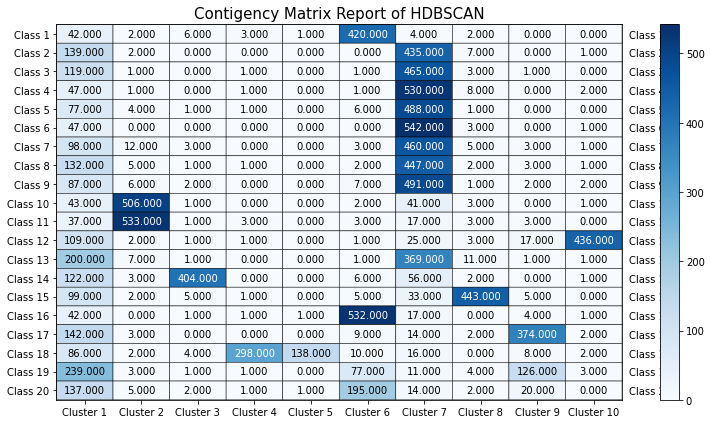

In [57]:
# best HDBSCAN with min_cluster_size = 100
hdbscan_umap = HDBSCAN(min_cluster_size=100)
hdbscan_umap.fit(X_train_umap)

# evaluation
hdbscan_umap_score = cluster_evaluation(X_train_umap, 
                                        newsgroups_train.target, 
                                        hdbscan_umap.labels_)

# visualize contigency matrix
cmat_hdbscan = contingency_matrix(newsgroups_train.target, hdbscan_umap.labels_)
unique_clusters_hdbscan, cluster_sizes_hdbscan = np.unique(hdbscan_umap.labels_,
                                                           return_counts=True)
xlabels = [f'Cluster {i+1}' for i in range(len(unique_clusters_hdbscan))]
ylabels = [f'Class {i+1}' for i in range(len(unique_labels))]
cmat_title = 'Contigency Matrix Report of HDBSCAN'
plot_mat(mat=cmat_hdbscan, size=(10, 6),
         xticklabels=xlabels, yticklabels=ylabels,
         title=cmat_title, pic_fname=cmat_title)

<div class="alert alert-block alert-success">
<b>QUESTION 16:</b> Contingency matrix
    
Plot the contingency matrix for the best clustering model from Question 15.
    
How many clusters are given by the model? What does “-1” mean for the clustering labels?
    
<b>Interpret the contingency matrix considering the answer to these questions.</b>
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 16:</b> The result of the contigency matrix is plotted above. In total, 10 clusters are returned by the HDBSCAN model instead of 20 as labeled in the ground truth. This reduction of 10 classes is caused by the misclustering of classes, which can be observed in the contingency matrix. For example, class 2-9 and 13 are all assigned to cluster 7, which is a reduction of 8 classes, and class 10 and 11 are assigned to cluster 2, a reduction of 1 classes. More similar cases can be observed above. Furthermore, a single class can also be splitted into multiple clusters. For example, class 20 are clustered mainly into 2 different clusters, i.e. cluster 1, 6. As for the "-1" in the clustering labels, it means that the data points are alone or have less than min_sample neighbors in the eps neighbourhood and are considered as noise.
</div>

#### Computing grid search to find the best dimensionality reduction technique and clustering methods that work best together for 20-class text data.

Add a timeout for the options that take too long. You are right to think that combinations that do not converge fast are likely not good models. 

In [ ]:
# !pip install umap-learn
# !pip install hdbscan

In [23]:
# import all necessary libraries

# dataset, vectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
# dimensionality reduction
from sklearn.decomposition import TruncatedSVD, NMF
from umap import UMAP
# clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from hdbscan import HDBSCAN
# evaluation
from sklearn.metrics import homogeneity_score, completeness_score
from sklearn.metrics import v_measure_score, rand_score
from sklearn.metrics import adjusted_rand_score, silhouette_score
# save file
import joblib
# create table
import pandas as pd
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# plot
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from plotmat import plot_mat

In [3]:
# load the input data
removed_items = ('headers', 'footers')
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=removed_items,
                                      shuffle=True,
                                      random_state=0)
unique_labels, category_sizes = np.unique(newsgroups_train.target, 
                                          return_counts=True)

# convert to TF-IDF matrix
min_df = 3
tfidf_vec = TfidfVectorizer(min_df=min_df, stop_words='english')
X_train_tfidf = tfidf_vec.fit_transform(newsgroups_train.data)
X_train_tfidf = X_train_tfidf.todense()

In [ ]:
# =============================================================== #
# Dimensionality Reduction:
#   To speed up the runtime, I will just generate the 
#   dimension-reduced features with all different required 
#   techniques at here, save them, and call them out later 
#   for grid search. 
# =============================================================== #

# init
path = "/content/drive/MyDrive/Colab Notebooks/ECE_219/Project2/Q17_grid_search"
rs = [5, 20, 200]

# # None
# joblib.dump(X_train_tfidf, f'{path}/DR_None.pkl')

for r in rs:
    # SVD
    svd = TruncatedSVD(n_components=r, n_iter=5, random_state=0)
    X_train_svd = svd.fit_transform(X_train_tfidf)
    joblib.dump(X_train_svd, f'{path}/DR_SVD_{r}.pkl')

    # NMF
    '''
    For n_components=200 in NMF, I have waited over 1 hour to generate the
    dimensional-reduced metrix but still haven't finished yet. Thus, I just 
    interrupt the process and decide not to test this one in the grid search.
    Otherwise, I have no idea how long I am supposed to wait.
    Hope that's ok and you can understand that.
    '''
    nmf = NMF(n_components=r, init='random', random_state=0)
    W_nmf = nmf.fit_transform(X_train_tfidf)
    joblib.dump(W_nmf, f'{path}/DR_NMF_{r}.pkl')

    # UMAP
    umap = UMAP(n_components=r, metric='cosine', random_state=0)
    X_train_umap = umap.fit_transform(X_train_tfidf)
    joblib.dump(X_train_umap, f'{path}/DR_UMAP_{r}.pkl')

In [19]:
# ================================================================== #
# Clustering:
#   Start the costum grid seach for all different clustering methods
'''
For the original dataset (without dimensionality reduction), it takes
me over 1 hour to just run one K-Mean k=5 model and still have finished
because Colab suffers from RAM issue or interruption. Therefore, I didn't
test this dataset. However, it is also assumed that if a model take too
long to converge, it is likely not a good model.
'''
# ================================================================== #

# function for calculating all cluster measures
def cluster_evaluation(X, y_true, y_pred):
    score = {}
    score["Homogeneity"] = homogeneity_score(y_true, y_pred)
    score["Completeness"] = completeness_score(y_true, y_pred)
    score["V-measure"] = v_measure_score(y_true, y_pred)
    score["Adjusted Rand-Index"] = adjusted_rand_score(y_true, y_pred)
    score["Silhouette Coefficient"] = silhouette_score(X, y_pred)
    
    return score

# parameters
K = [10, 20, 50]
N_CLUSTERS = [20]
MIN_CLUSTER_SIZE = [100, 200]
path = "/content/drive/MyDrive/Colab Notebooks/ECE_219/Project2/Q17_grid_search"
dr_names = ['DR_SVD_5', 'DR_SVD_20', 'DR_SVD_200',
            'DR_NMF_5', 'DR_NMF_20',
            'DR_UMAP_5', 'DR_UMAP_20', 'DR_UMAP_200']
score_names = ['Homogeneity', "Completeness", "V-measure", 
               "Adjusted Rand-Index", "Silhouette Coefficient"]

# init
X_train_dr = {}
y_train_dr = {}
df_grid_results = pd.DataFrame()

# get multiple dimension-reduced features datasets
for name in dr_names:
    X_train_dr[name] = joblib.load(f'{path}/{name}.pkl')
    y_train_dr[name] = newsgroups_train.target

# run costum grid search 
for key in X_train_dr.keys():
    # K-Means
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=50, random_state=0)
        kmeans.fit(X_train_dr[key])
        kmeans_score = cluster_evaluation(X_train_dr[key], y_train_dr[key], 
                                          kmeans.labels_)
        # save
        df_temp = pd.DataFrame([kmeans_score])
        df_temp['dataset'] = key
        df_temp['cluster'] = f'K-Means_{k}'
        df_grid_results = df_grid_results.append(df_temp, ignore_index=True)

    # Agglomerative Clustering
    for n in N_CLUSTERS:
        ac = AgglomerativeClustering(n_clusters=n, linkage='ward')
        ac.fit(X_train_dr[key])
        ac_score = cluster_evaluation(X_train_dr[key], y_train_dr[key], 
                                      ac.labels_)
        # save
        df_temp = pd.DataFrame([ac_score])
        df_temp['dataset'] = key
        df_temp['cluster'] = f'Agglomerative_{n}'
        df_grid_results = df_grid_results.append(df_temp, ignore_index=True)

    # HDBSCAN
    for i in MIN_CLUSTER_SIZE:
        hdbscan = HDBSCAN(min_cluster_size=i, allow_single_cluster=True)
        hdbscan.fit(X_train_dr[key])
        hdbscan_score = cluster_evaluation(X_train_dr[key], y_train_dr[key], 
                                           hdbscan.labels_)
        # save
        df_temp = pd.DataFrame([hdbscan_score])
        df_temp['dataset'] = key
        df_temp['cluster'] = f'HDBSCAN_{i}'
        df_grid_results = df_grid_results.append(df_temp, ignore_index=True)


# save and show the results
df_grid_results = df_grid_results[['dataset', 'cluster'] + score_names]
file_path = "/content/drive/MyDrive/Colab Notebooks/ECE_219/Project2"
df_grid_results.to_csv(f'{file_path}/Q17_grid_result.csv')
df_grid_results

,dataset,cluster,Homogeneity,Completeness,V-measure,Adjusted Rand-Index,Silhouette Coefficient
0,DR_SVD_5,K-Means_10,0.261162,0.394300,0.314209,0.104391,0.254827
1,DR_SVD_5,K-Means_20,0.315292,0.344534,0.329265,0.121766,0.206593
2,DR_SVD_5,K-Means_50,0.370342,0.301902,0.332638,0.099294,0.176643
3,DR_SVD_5,Agglomerative_20,0.309765,0.335864,0.322287,0.120045,0.131434
4,DR_SVD_5,HDBSCAN_100,0.001266,0.074801,0.002489,-0.000018,-0.227272
5,DR_SVD_5,HDBSCAN_200,0.003453,0.116210,0.006707,0.000017,-0.270529
6,DR_SVD_20,K-Means_10,0.253368,0.421529,0.316498,0.076011,0.138883
7,DR_SVD_20,K-Means_20,0.345174,0.392752,0.367429,0.129206,0.167457
8,DR_SVD_20,K-Means_50,0.442500,0.365119,0.400102,0.149595,0.113689
9,DR_SVD_20,Agglomerative_20,0.367527,0.423065,0.393346,0.148674,0.124816


In [13]:
# plot out the best result
score_names = ['Homogeneity', "Completeness", "V-measure", 
               "Adjusted Rand-Index", "Silhouette Coefficient"]

best_results = {}
for name in score_names:
    cur_best = {}
    best_idx = np.argmax(df_grid_results[name])
    best_value = np.max(df_grid_results[name])
    best_dataset = df_grid_results['dataset'][best_idx]
    best_cluter = df_grid_results['cluster'][best_idx]
    best_results[name] = [best_dataset, best_cluter, best_value]

cols = ['best_dataset', 'best_cluter', 'best_value']
best_results = pd.DataFrame.from_dict(best_results, orient='index', columns=cols)
best_results = best_results.style.set_caption("Best Setting for each evaluation metric")
best_results

,best_dataset,best_cluter,best_value
Homogeneity,DR_UMAP_200,K-Means_50,0.628740
Completeness,DR_UMAP_200,K-Means_10,0.654378
V-measure,DR_UMAP_200,K-Means_20,0.583932
Adjusted Rand-Index,DR_UMAP_200,K-Means_20,0.459044
Silhouette Coefficient,DR_UMAP_5,K-Means_10,0.438730


<div class="alert alert-block alert-success">
<b>QUESTION 17:</b> Based on your experiments, which dimensionality reduction technique and clustering methods worked best together for 20-class text data and why? Follow the table below. If UMAP takes too long to converge, consider running it once and saving the intermediate results in a pickle file.
    
Hint: DBSCAN and HDBSCAN do not accept the number of clusters as an input parameter. So pay close attention to how the different clustering metrics are being computed for these methods.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 17:</b> Based on the "Best Setting for each evaluation metric" table shown above, the best dimensionality reduction technique can be easily concluded to the UMAP with a reduction to 200 features as it demonstrates to be the best dataset in 4 out of 5 evaluation metrics. To decide the best clustering method, I dive deep into the table of all experiment results, especially the part with UMAP and 200 features. One can notice that for each K-Means model, i.e. $k = 10, 20, 50$, They all have their advantages. $k = 10$, for example, has the highest completeness scores, $k = 50$ has the highest homogeneity, and $k = 20$ performs somewhere in between and thus with the highest v-measure score, which is per definition an average of homogeneity score and completeness score. However, further taking the adjusted rand-index into consideration, it can be conculded that the best clustering method is K-Means with $k = 20$, which yields the highest adjusted rand-index score. This result makes sense as the number of classes in newsgroups dataset ground truth is also 20. 
</div>

In [ ]:
# ================================================================== #
'''
Grid Search:
  Another way to complete the grid search with GridSearchCV.
  But there are lots of problems so I decide not to use this one.
  The whole pipeline, however, looks like the followings.
'''
# ================================================================== #

# # add prediction function in AgglomerativeClustering
# # to avoid error in grid search
# class AgglomerativeClusteringWrapper(AgglomerativeClustering):
#     def predict(self, X):
#         return self.labels_.astype(int)

# # set up pipeline
# pipeline = Pipeline([('cluster', KMeans())])

# # parameters
# K = [10, 20, 50]
# N_CLUSTERS = [20]
# MIN_CLUSTER_SIZE = [100, 200]

# # grid parameters
# param_grid = [
#     {
#         'cluster': [KMeans(max_iter=1000, n_init=50, 
#                            random_state=0)],
#         'cluster__n_clusters': K,
#         # 3 choices
#     },
#     {
#         'cluster': [AgglomerativeClusteringWrapper(linkage='ward')],
#         'cluster__n_clusters': N_CLUSTERS,
#         # 1 choice
#     },
#     {
#         'cluster': [HDBSCAN(metric='euclidean',
#                             cluster_selection_method='eom')],
#         'cluster__min_cluster_size': MIN_CLUSTER_SIZE,
#         # 2 choices
#     },
#     # 3 + 1 + 2 = 6 choices in total
# ]

# # init
# path = "/content/drive/MyDrive/Colab Notebooks/ECE_219/Project2/Q17_grid_search"
# dr_names = ['DR_None', 
#             'DR_SVD_5', 'DR_SVD_20', 'DR_SVD_200',
#             'DR_NMF_5', 'DR_NMF_20', 'DR_NMF_200',
#             'DR_UMAP_5', 'DR_UMAP_20', 'DR_UMAP_200']
# scoring = ['homogeneity_score', 'completeness_score', 
#            'v_measure_score', 'adjusted_rand_score']
# X_train_dr = {}
# y_train_dr = {}
# df_grid_results = pd.DataFrame()

# # get multiple dimension-reduced features datasets
# for name in dr_names:
#     X_train_dr[name] = joblib.load(f'{path}/{name}.pkl')
#     y_train_dr[name] = newsgroups_train.target

# for key in X_train_dr.keys():
#     # run grid search 
#     grid = GridSearchCV(estimator=pipeline, 
#                         param_grid=param_grid, 
#                         scoring=scoring, 
#                         ) # refit='adjusted_rand_score'
#     grid.fit(X_train_dr[key], y_train_dr[key])

#     # save the grid search results in the data frame
#     df_temp = pd.DataFrame(grid.cv_results_)
#     df_temp['dataset'] = key
#     df_grid_results = df_grid_results.append(df_temp, ignore_index=True)

# # show the results
# get_values = lambda x: '_'.join(str(val) for val in x.values())
# index_names = df_grid_results['params'].apply(get_values)
# df_grid_results = df_grid_results.set_index(index_names).rename_axis('kernel')
# df_grid_results[['kernel'] + scoring]

#### Extra Credit

Try to further improve the clustering performance of the best found model in Q17, which is UMAP with 200 features as dimensionality reduction technique and K-Means with 20 clusters as clustering methos.

In [55]:
# old best found performance 
umap_score_old = {'Homogeneity': 0.5757967524019446,
                  'Completeness': 0.5923011716943956,
                  'V-measure': 0.5839323640085016,
                  'Adjusted Rand-Index': 0.4590439375224452,
                  'Silhouette Coefficient': 0.369268}

# set up UMAP
umap = UMAP(n_components=300, metric='cosine', random_state=0, 
            n_neighbors=30)
X_train_umap = umap.fit_transform(X_train_tfidf)

# set up K-Means
umap_kmeans = KMeans(n_clusters=20, max_iter=1000, n_init=50, 
                     random_state=0)
umap_kmeans.fit(X_train_umap)

# new best found performance 
umap_score_new = cluster_evaluation(X_train_umap, newsgroups_train.target,
                                    umap_kmeans.labels_)

# show
idx_names = ['old best found performance', 'new best found performance']
compare_df = pd.DataFrame([umap_score_old, umap_score_new], index=idx_names)
compare_df

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


,Homogeneity,Completeness,V-measure,Adjusted Rand-Index,Silhouette Coefficient
old best found performance,0.575797,0.592301,0.583932,0.459044,0.369268
new best found performance,0.584414,0.619583,0.601485,0.454362,0.389403


<div class="alert alert-block alert-success">
<b>QUESTION 18:</b> Extra credit: If you can find creative ways to further enhance the clustering
performance, report your method and the results you obtain.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 18:</b> The slightly improved performance is shown above. I found out that by increasing the n_components to 300 and n_neighbors to 30, the model can yields slightly higher performance.
</div>

# Part 2 - Deep Learning and Clustering of Image Data

<div class="alert alert-block alert-success">
<b>QUESTION 19:</b> In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 19:</b> 
Because a pre-trained model can potentially understand the features in a new custom dataset, which might have a certain degree of similarity in features, weights, etc., with respected to the pre-trained dataset. Therefore, by applying transfer learning in leveraging the knowledge it learned from the previously trained models, it can achieves optimal performance faster than the traditional ML models and have discriminative power. Even though the custom dataset does not look similar to the pre-trained dataset, such pre-trained model still has the capability to morph the highly non-smooth raw data input in higher dimension into a relative smoother lower-dimensional space if the pre-trained model is generalized well enough.
</div>

#### Use the helper code to load the flowers dataset, and extract their features. To perform computations on deep neural networks fast enough, GPU resources are often required. GPU resources can be freely accessed through “Google Colab”.

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

## Flowers Dataset and VGG Features

In [3]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 58/58 [00:42<00:00,  1.36it/s]


<div class="alert alert-block alert-success">
<b>QUESTION 20:</b> In a brief paragraph explain how the helper code base is performing feature extraction.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 20:</b> The helper code first use the pre-trained VGG-16 feature layers to extract the intermediate representation of the input image, which is then processed by a VGG-16 average pooling layer. After that, the processed intermediate representation is flattened into one-dimensional vector with a flatten layer and output the final extracted feature vector through the first part of FC layer of the pretrained VGG-16 model.
</div>

In [4]:
import matplotlib.image as mpimg

# How many pixels are there in the original images?
img1 = mpimg.imread('/content/flower_photos/daisy/10140303196_b88d3d6cec.jpg')
print('Shape of the original image 1: {}'.format(img1.shape))
img2 = mpimg.imread('/content/flower_photos/roses/10894627425_ec76bbc757_n.jpg')
print('Shape of the original image 2: {}'.format(img2.shape))
img3 = mpimg.imread('/content/flower_photos/sunflowers/10386503264_e05387e1f7_m.jpg')
print('Shape of the original image 3: {}'.format(img3.shape))

# shape of the batch in dataloader
batch_shape = next(iter(dataloader))[0].shape
print('Shape of each loaded batch: {}'.format(batch_shape))

# How many features does the VGG network extract per image?
num_samples = y_all.shape[0]
num_features = f_all.shape[1]
print("Shape of the each extracted feature vector: {}".format(num_features))
print("Number of total images samples: {}".format(num_samples))

Shape of the original image 1: (313, 500, 3)
Shape of the original image 2: (231, 320, 3)
Shape of the original image 3: (231, 240, 3)
Shape of each loaded batch: torch.Size([64, 3, 224, 224])
Shape of the each extracted feature vector: 4096
Number of total images samples: 3670


<div class="alert alert-block alert-success">
<b>QUESTION 21:</b> How many pixels are there in the original images? How many features does the VGG network extract per image; i.e what is the dimension of each feature vector for an image sample?
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 21:</b> The number of pixels in the original images (flower photos folder) varies between each image. Some examples of dimension here can be (313, 500, 3), (231, 320, 3), or (231, 240, 3). Therefore, we can only be certain that the original images are all RGB-image. The size of the loaded images in the dataloader, however, can be certain since a resize transformation to 224 is applied. Hense each loaded image has $224 \times 224 \times 3 = 150528$ pixels. The final extracted feature vector of an image has a dimension of 4096. 
</div>

In [5]:
# print the number of nonzero elements 
# in the extracted featuress
num_zeros_per_vector = (f_all==0).sum(axis=1)
num_sample_w0 = (num_zeros_per_vector!=0).sum().astype(int)
print('Number of feature vectors with zero inside: {}'.format(num_sample_w0))

Number of feature vectors with zero inside: 0


<div class="alert alert-block alert-success">
<b>QUESTION 22:</b> Are the extracted features dense or sparse? (Compare with sparse TF-IDF features in text.)
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 22:</b> The extracted features are dense as there are basically no zero elements in the feature vectors.
</div>

### Apply t-SNE and visualize the ground truth clustering of the extracted features

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


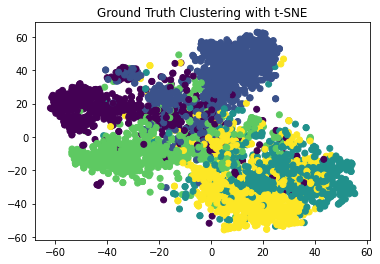

In [6]:
from sklearn.manifold import TSNE

f_tsne = TSNE(n_components=2).fit_transform(f_all)
plt.scatter(*f_tsne.T, c=y_all)
plt.title("Ground Truth Clustering with t-SNE")
plt.show()

<div class="alert alert-block alert-success">
<b>QUESTION 23:</b> In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with ground-truth labels. Describe your observation.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 23:</b> The plot is shown above. At the first glance, one can notice that there are in total 5 different colors, indicating a total of 5 different class label in ground truth. Moreover, based on the distribution, we know that the data points scatter messily, even just within the same class, and there are a lot of overlappings. This can potentially cause huge difficulty with clustering techniques and thus, achieving a good result might not be possible.
</div>

### Computing grid search to find the best dimensionality reduction technique and clustering methods that work best together for image data.


In [8]:
# !pip install umap-learn
# !pip install hdbscan

In [9]:
# import all necessary libraries

# dataset, vectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
# dimensionality reduction
from sklearn.decomposition import TruncatedSVD, NMF
from umap import UMAP
# clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from hdbscan import HDBSCAN
# evaluation
from sklearn.metrics import homogeneity_score, completeness_score
from sklearn.metrics import v_measure_score, rand_score
from sklearn.metrics import adjusted_rand_score, silhouette_score
# save file
import joblib
# create table
import pandas as pd
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# plot
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from plotmat import plot_mat

#### Helper function: Autoencoder

In [10]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [12]:
# =============================================================== #
# Dimensionality Reduction:
#   To speed up the runtime, I will just generate the 
#   dimension-reduced features with all different required 
#   techniques at here, save them, and call them out later 
#   for grid search. 
# =============================================================== #

# init
path = "/content/drive/MyDrive/Colab Notebooks/ECE_219/Project2/Q24_grid_search"
r = 50

# None
joblib.dump(f_all, f'{path}/DR_None.pkl')

# SVD
svd = TruncatedSVD(n_components=r, n_iter=5, random_state=0)
f_all_svd = svd.fit_transform(f_all)
joblib.dump(f_all_svd, f'{path}/DR_SVD_{r}.pkl')

# UMAP
umap = UMAP(n_components=r, metric='cosine', random_state=0)
f_all_umap = umap.fit_transform(f_all)
joblib.dump(f_all_umap, f'{path}/DR_UMAP_{r}.pkl')

# NMF
ae = Autoencoder(n_components=r)
f_all_ae = ae.fit_transform(f_all)
joblib.dump(f_all_ae, f'{path}/DR_AE_{r}.pkl')

In [13]:
# # ================================================================== #
# # Clustering:
# #   Start the costum grid seach for all different clustering methods
# # ================================================================== #

# function for calculating all cluster measures
def cluster_evaluation(X, y_true, y_pred):
    score = {}
    score["Homogeneity"] = homogeneity_score(y_true, y_pred)
    score["Completeness"] = completeness_score(y_true, y_pred)
    score["V-measure"] = v_measure_score(y_true, y_pred)
    score["Adjusted Rand-Index"] = adjusted_rand_score(y_true, y_pred)
    score["Silhouette Coefficient"] = silhouette_score(X, y_pred)
    
    return score

# parameters
K = [5]
N_CLUSTERS = [5]
MIN_CLUSTER_SIZE = [100, 200]
MIN_SAMPLES = [5, 20, 50]
path = "/content/drive/MyDrive/Colab Notebooks/ECE_219/Project2/Q24_grid_search"
dr_names = ['DR_SVD_50', 'DR_UMAP_50', 'DR_AE_50', 'DR_None']
score_names = ['Homogeneity', "Completeness", "V-measure", 
               "Adjusted Rand-Index", "Silhouette Coefficient"]

# init
X_train_dr = {}
y_train_dr = {}
df_grid_results = pd.DataFrame()

# get multiple dimension-reduced features datasets
for name in dr_names:
    X_train_dr[name] = joblib.load(f'{path}/{name}.pkl')
    y_train_dr[name] = y_all

# run costum grid search 
for key in X_train_dr.keys():
    # K-Means
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=50, random_state=0)
        kmeans.fit(X_train_dr[key])
        kmeans_score = cluster_evaluation(X_train_dr[key], y_train_dr[key], 
                                          kmeans.labels_)
        # save
        df_temp = pd.DataFrame([kmeans_score])
        df_temp['dataset'] = key
        df_temp['cluster'] = f'K-Means_{k}'
        df_grid_results = df_grid_results.append(df_temp, ignore_index=True)

    # Agglomerative Clustering
    for n in N_CLUSTERS:
        ac = AgglomerativeClustering(n_clusters=n, linkage='ward')
        ac.fit(X_train_dr[key])
        ac_score = cluster_evaluation(X_train_dr[key], y_train_dr[key], 
                                      ac.labels_)
        # save
        df_temp = pd.DataFrame([ac_score])
        df_temp['dataset'] = key
        df_temp['cluster'] = f'Agglomerative_{n}'
        df_grid_results = df_grid_results.append(df_temp, ignore_index=True)

    # HDBSCAN
    for i in MIN_CLUSTER_SIZE:
        for j in MIN_SAMPLES:
            hdbscan = HDBSCAN(min_cluster_size=i, min_samples=j, 
                              allow_single_cluster=True)
            hdbscan.fit(X_train_dr[key])
            hdbscan_score = cluster_evaluation(X_train_dr[key], y_train_dr[key], 
                                              hdbscan.labels_)
            # save
            df_temp = pd.DataFrame([hdbscan_score])
            df_temp['dataset'] = key
            df_temp['cluster'] = f'HDBSCAN_mcs{i}_ms{j}'
            df_grid_results = df_grid_results.append(df_temp, ignore_index=True)


# save and show the results
df_grid_results = df_grid_results[['dataset', 'cluster'] + score_names]
file_path = "/content/drive/MyDrive/Colab Notebooks/ECE_219/Project2"
df_grid_results.to_csv(f'{file_path}/Q24_grid_result.csv')
df_grid_results

,dataset,cluster,Homogeneity,Completeness,V-measure,Adjusted Rand-Index,Silhouette Coefficient
0,DR_SVD_50,K-Means_5,0.325666,0.360670,0.342275,0.190924,0.105477
1,DR_SVD_50,Agglomerative_5,0.323964,0.404694,0.359857,0.146931,0.081855
2,DR_SVD_50,HDBSCAN_mcs100_ms5,0.003507,0.044884,0.006506,-0.001395,-0.131005
3,DR_SVD_50,HDBSCAN_mcs100_ms20,0.004508,0.057688,0.008363,-0.001117,-0.141515
4,DR_SVD_50,HDBSCAN_mcs100_ms50,0.003185,0.040759,0.005909,-0.000968,-0.143962
5,DR_SVD_50,HDBSCAN_mcs200_ms5,0.006856,0.051856,0.012110,-0.001988,-0.115738
6,DR_SVD_50,HDBSCAN_mcs200_ms20,0.005830,0.044101,0.010299,-0.001794,-0.123952
7,DR_SVD_50,HDBSCAN_mcs200_ms50,0.005453,0.041246,0.009632,-0.001612,-0.124261
8,DR_UMAP_50,K-Means_5,0.530458,0.542850,0.536582,0.467338,0.503066
9,DR_UMAP_50,Agglomerative_5,0.521732,0.538785,0.530121,0.458874,0.498167


In [14]:
# plot out the best result
score_names = ['Homogeneity', "Completeness", "V-measure", 
               "Adjusted Rand-Index", "Silhouette Coefficient"]

best_results = {}
for name in score_names:
    cur_best = {}
    best_idx = np.argmax(df_grid_results[name])
    best_value = np.max(df_grid_results[name])
    best_dataset = df_grid_results['dataset'][best_idx]
    best_cluter = df_grid_results['cluster'][best_idx]
    best_results[name] = [best_dataset, best_cluter, best_value]

cols = ['best_dataset', 'best_cluter', 'best_value']
best_results = pd.DataFrame.from_dict(best_results, orient='index', columns=cols)
best_results = best_results.style.set_caption("Best Setting for each evaluation metric")
best_results

,best_dataset,best_cluter,best_value
Homogeneity,DR_UMAP_50,K-Means_5,0.530458
Completeness,DR_UMAP_50,HDBSCAN_mcs100_ms5,0.633782
V-measure,DR_UMAP_50,K-Means_5,0.536582
Adjusted Rand-Index,DR_UMAP_50,K-Means_5,0.467338
Silhouette Coefficient,DR_UMAP_50,HDBSCAN_mcs100_ms5,0.545895


<div class="alert alert-block alert-success">
<b>QUESTION 24:</b> Report the best result (in terms of rand score) within the table below. For HDBSCAN, introduce a conservative parameter grid over min_cluster_size and min_samples.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 24:</b> In terms of the adjusted rand-index, the best dimensionality reduction technique for image data is UMAP with feature size 50, and the best clustering model is K-Means with 5 clusters, which also makes sence as the number of the ground truth class in the image dataset is 5.
</div>

In [26]:
# best model scores
df_grid_results.iloc[8]

dataset                   DR_UMAP_50
cluster                    K-Means_5
Homogeneity                 0.530458
Completeness                 0.54285
V-measure                   0.536582
Adjusted Rand-Index         0.467338
Silhouette Coefficient      0.503066
Name: 8, dtype: object

#### Helper function: MLP model

In [129]:
from sklearn.metrics import accuracy_score

class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                # move to GPU
                X_ = X_.cuda()
                y_ = y_.cuda()
                # forward training
                output = self.forward(X_)
                loss = criterion(output, y_)
                # backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        # start evaluation mode
        with torch.no_grad():
            # move to GPU
            X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
            # start predicting
            self.model.eval()
            output = self.model(X_test)
            # convert softmax back to class label
            y_pred = np.argmax(output.cpu(), axis=1)
            # calculate accuracy
            acc = accuracy_score(y_test, y_pred)
        return acc

Train and test MLP classifier on the original VGG features without dimensionality reduction technique

In [135]:
# set up, train, and test MLP model
mlp = MLP(num_features=f_all.shape[1])
mlp = mlp.train(f_all, y_all)
acc = mlp.eval(f_all, y_all)
print(f"\n\nAccuracy of MLP model with original features: {acc*100}%")

100%|██████████| 100/100 [00:14<00:00,  6.96it/s]



Accuracy of MLP model with original features: 99.97275204359674%


Train and test MLP classifier on the original VGG features with dimensionality reduction technique

In [137]:
# set up UMAP
umap = UMAP(n_components=50, metric='cosine', random_state=0)
f_all_umap = umap.fit_transform(f_all)

# set up, train, and test MLP model
mlp = MLP(num_features=f_all_umap.shape[1])
mlp = mlp.train(f_all_umap, y_all)
acc = mlp.eval(f_all_umap, y_all)
print("\n\nAccuracy of MLP model with "\
      f"reduced-dimension features: {acc*100}%")


100%|██████████| 100/100 [00:08<00:00, 11.30it/s]



Accuracy of MLP model with reduced-dimension features: 82.28882833787466%


<div class="alert alert-block alert-success">
<b>QUESTION 25:</b> Report the test accuracy of the MLP classifier on the original VGG features.
    
Report the same when using the reduced-dimension features (you have freedom in choosing the dimensionality reduction algorithm and its parameters). Does the performance of the model suffer with the reduced-dimension representations? Is it significant? Does the success in classification make sense in the context of the clustering results obtained for the same features in Question 24.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 25:</b> Both test accuracies of the MLP with and without reduced-dimension features are reported above. With dimensionality reduction, a 82.29% accuracy is achieved, and without dimensionality reduction, a 99.97% accuracy is yielded. Therefore, it can be concluded that the model do suffer significantly from reduced-dimension representations as a great amount of information is lost during the data transformation. Even though I have chosen the best parameters setting I found previously for UMAP, a reduction of 18% perfomance can still be observed.

In my opinion, the success in classification does make sense in the context of the clustering results obtained for the same features in Question 24. Based on the scatter plot of ground truth in Q23, we already have the expectation that the clustering method might not be able to work well due to the high overlapping of data points. Indeed, even with the best clustering model demonstrated in Q24, K-Means, it only yields around 50% accuracy (best Adjusted Rand-Index is 46.73%). However, for the classification with MLP, since there are lots of non-linear layers, it is expected that the model have sort of non-linear capability and could somehow work around the data points and find the relatively correct boundary to seperate each classes. Therefore, a huge better performance compared to clustering is expected. This assumption is also proven by the experiment at here.
</div>